In [2]:
!wget http://www.dcs.warwick.ac.uk/~u1500912/Assignment2.zip

--2018-03-13 12:26:39--  http://www.dcs.warwick.ac.uk/~u1500912/Assignment2.zip
Resolving www.dcs.warwick.ac.uk (www.dcs.warwick.ac.uk)... 137.205.116.22
Connecting to www.dcs.warwick.ac.uk (www.dcs.warwick.ac.uk)|137.205.116.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211355323 (202M) [application/zip]
Saving to: ‘Assignment2.zip’

Assignment2.zip     100%[===================>] 201.56M  30.0MB/s    in 8.6s    

2018-03-13 12:26:48 (23.4 MB/s) - ‘Assignment2.zip’ saved [211355323/211355323]



In [1]:
!ls


Assignment2	 datalab	     mlp_data_aug.csv  mlp_watershed.csv
Assignment2.zip  mlp_data_aug_2.csv  mlp_data_aug.h5   mlp_watershed.h5


In [2]:
!unzip Assignment2

Archive:  Assignment2.zip
replace Assignment2/SampleTraining/sample_train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
!pip install tqdm
!pip install keras

    100% |████████████████████████████████| 61kB 3.0MB/s 


In [0]:
# Code

In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import  Conv2D, AtrousConvolution2D
from keras.layers import  Deconvolution2D, merge
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'Assignment2/FullTraining/'
TEST_PATH = 'Assignment2/FullTesting/'


Using TensorFlow backend.


In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids)*4, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
x_train_dict = dict()
x_test_dict = dict()
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train_dict[n] = id_
    X_train[n] = img  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test_dict[n] = id_
    X_test[n] = img
# print(x_train_dict)

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:48<00:00,  3.97it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 46.34it/s]


In [0]:
X_train_stand = (X_train - X_train.mean())/X_train.std()
X_test_stand = (X_test - X_test.mean())/X_test.std()

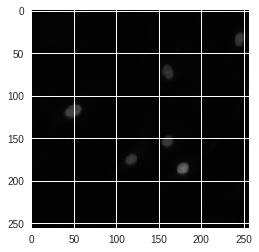

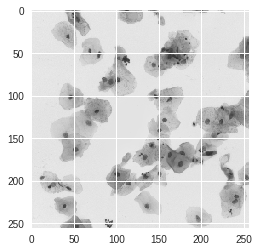

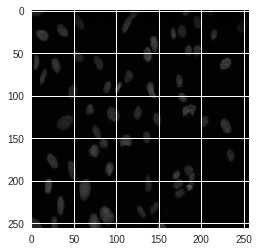

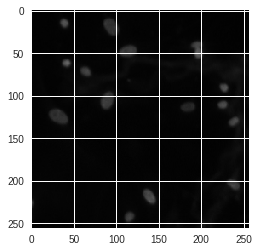

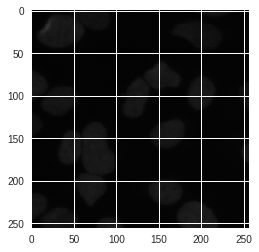

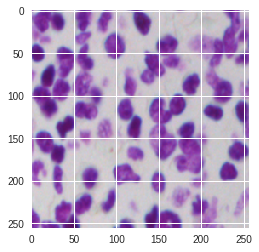

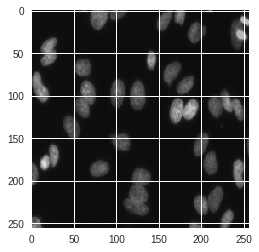

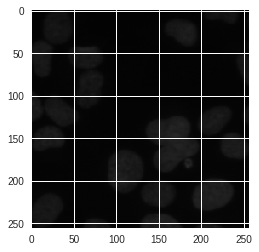

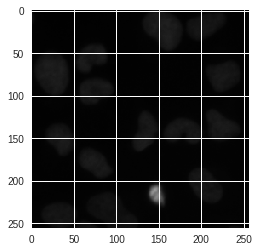

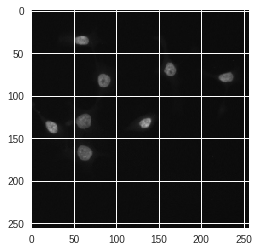

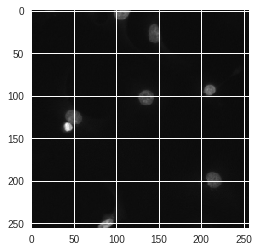

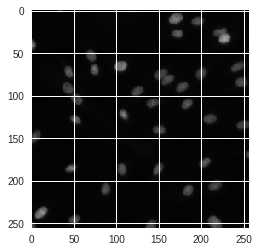

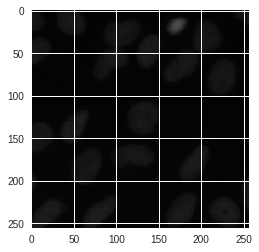

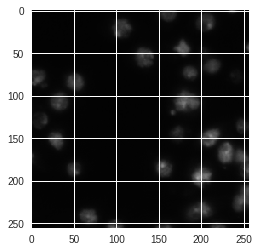

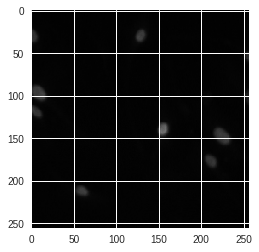

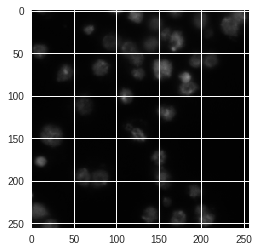

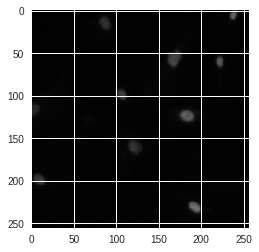

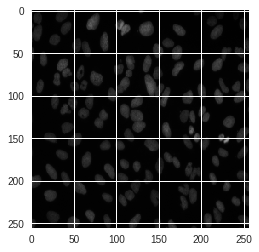

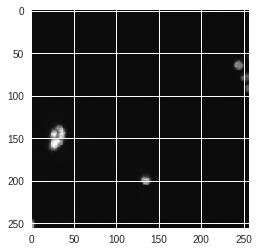

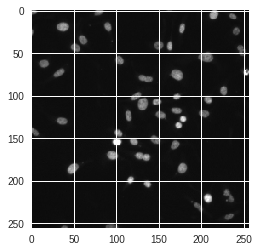

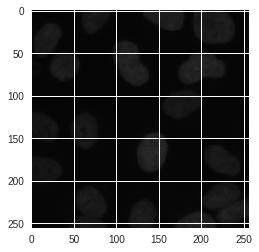

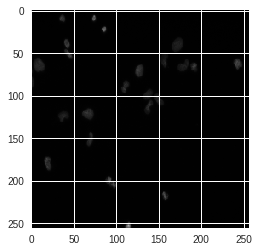

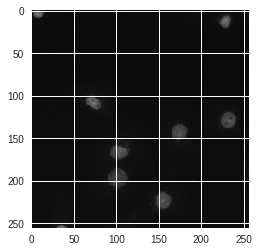

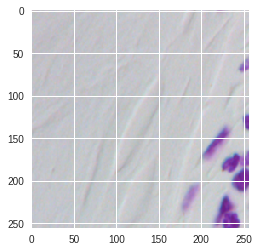

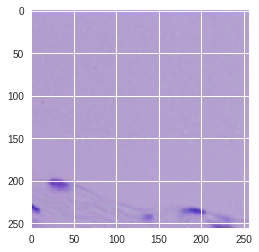

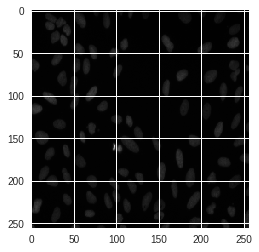

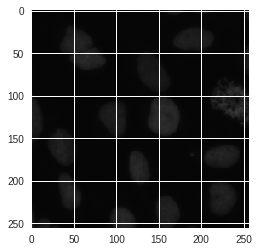

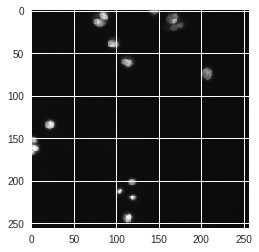

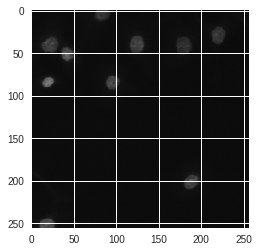

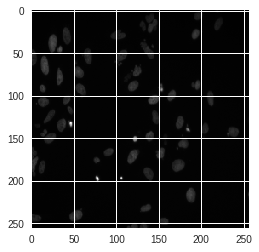

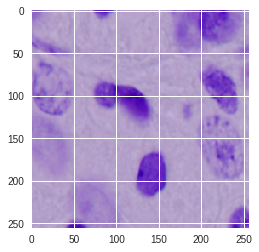

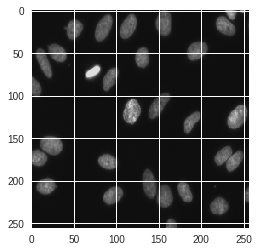

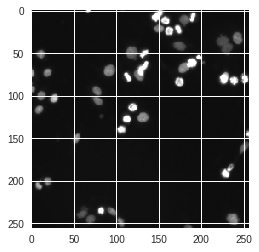

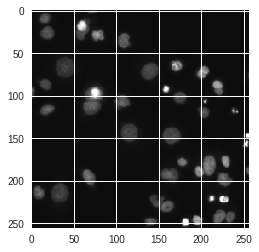

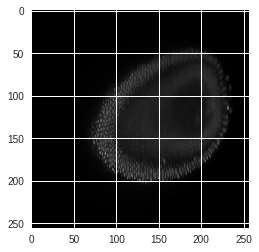

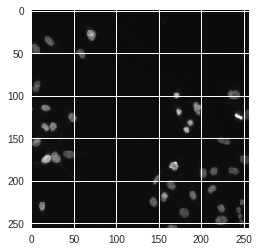

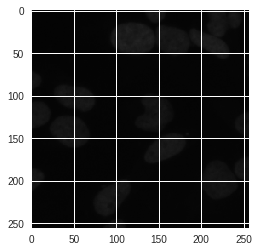

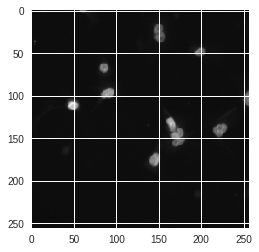

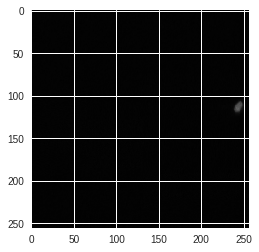

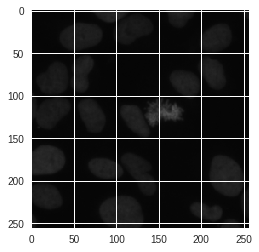

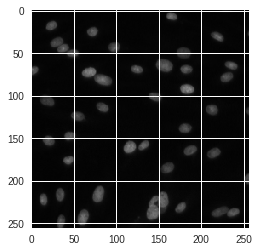

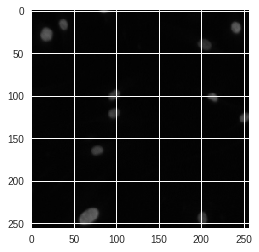

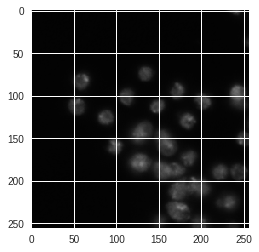

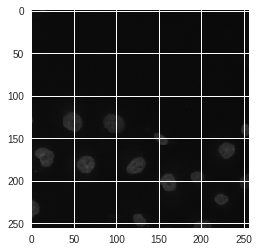

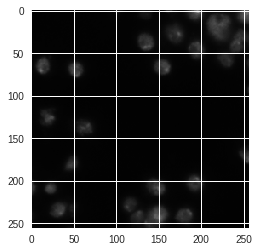

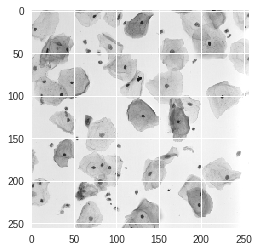

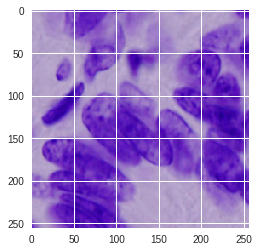

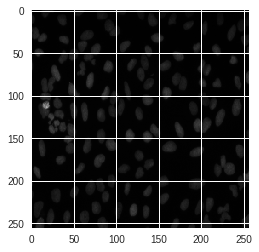

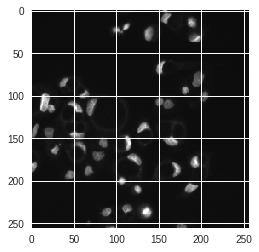

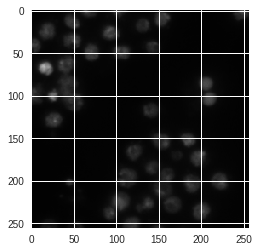

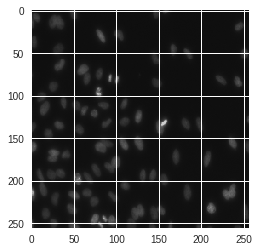

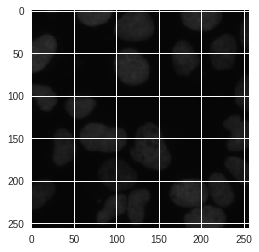

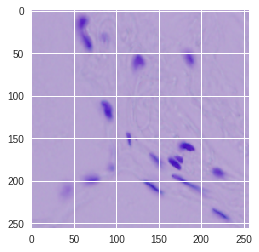

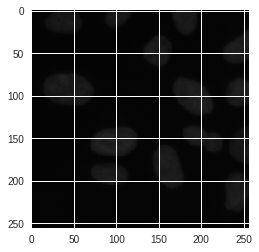

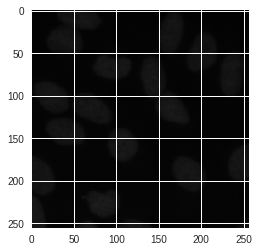

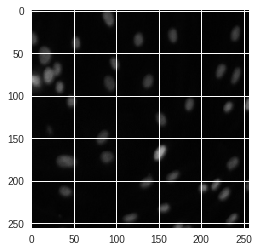

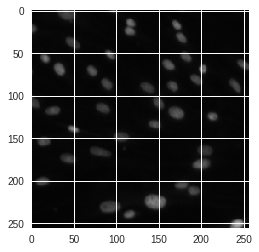

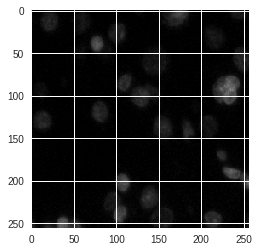

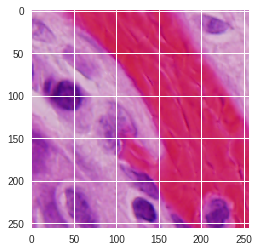

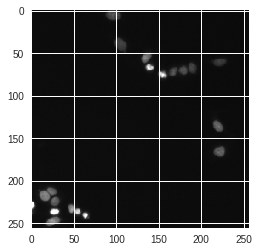

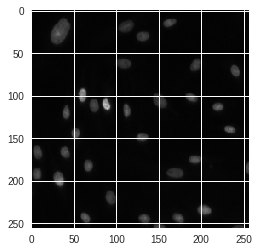

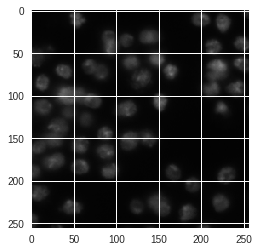

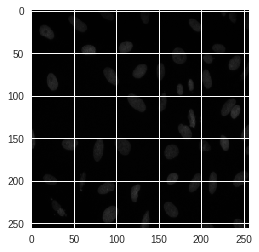

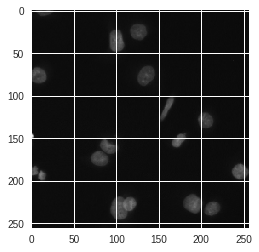

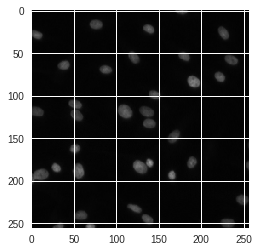

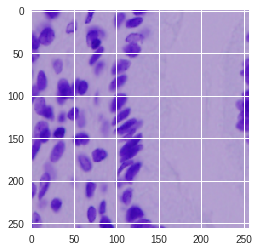

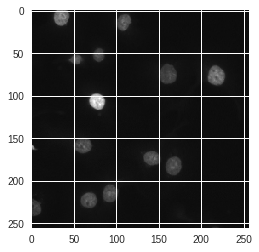

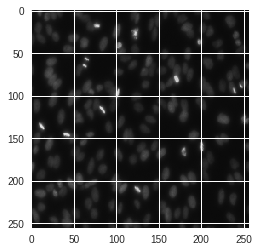

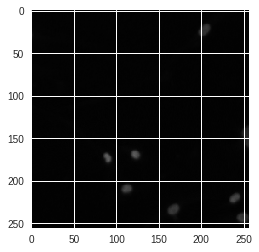

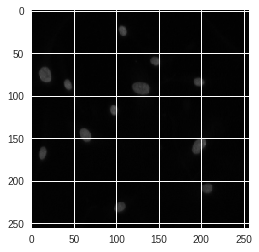

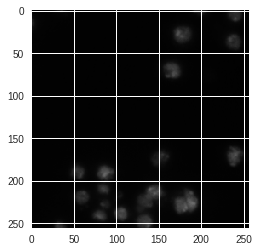

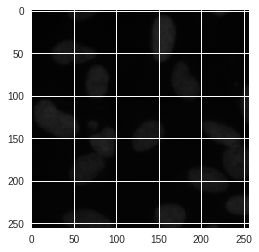

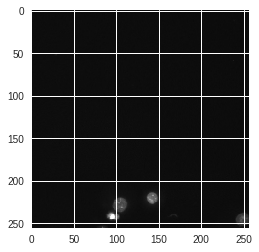

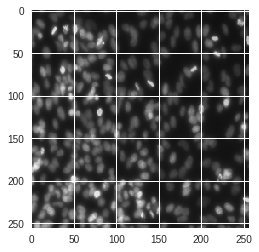

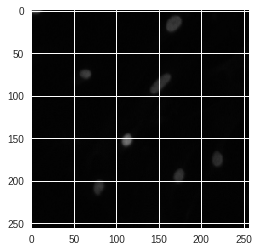

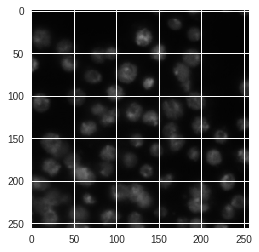

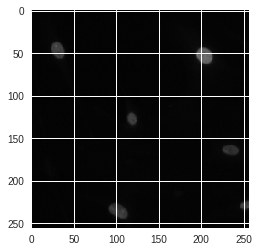

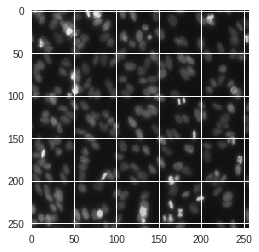

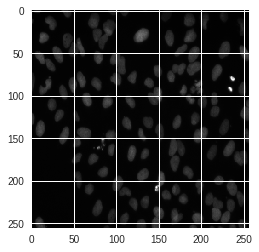

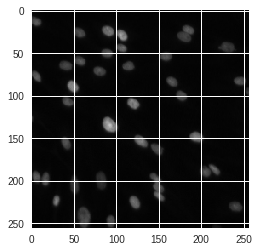

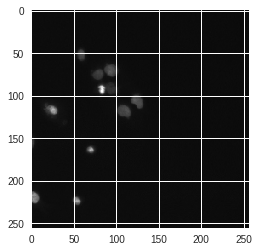

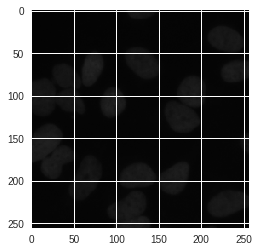

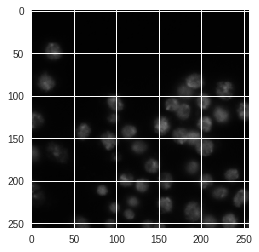

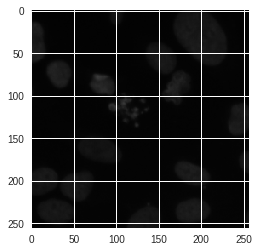

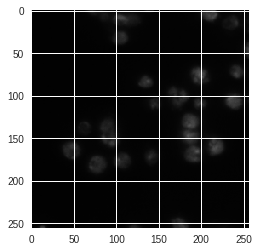

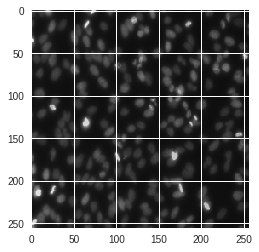

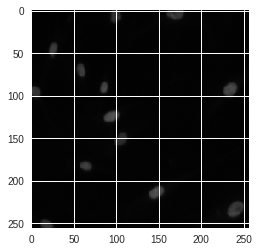

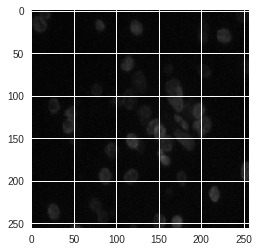

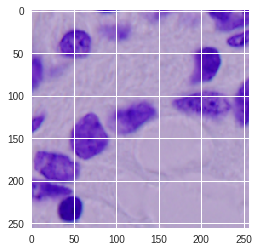

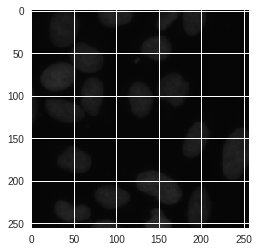

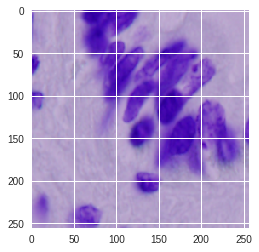

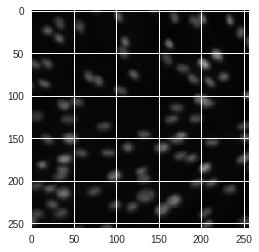

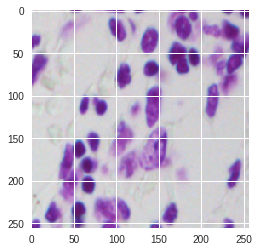

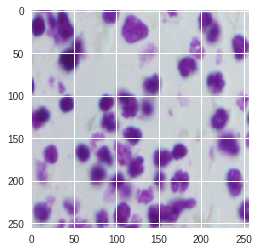

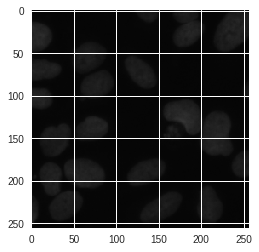

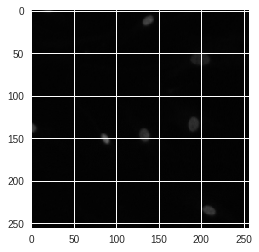

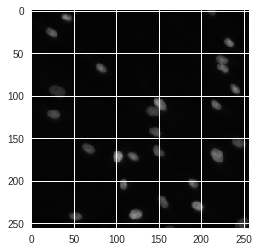

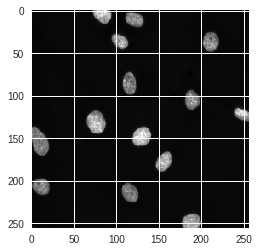

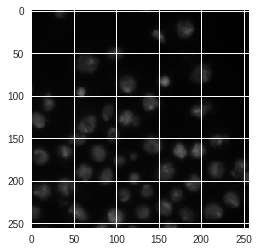

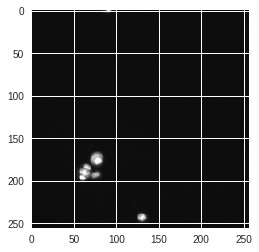

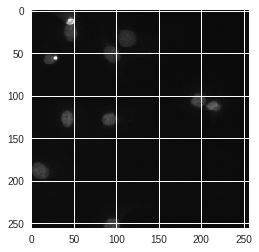

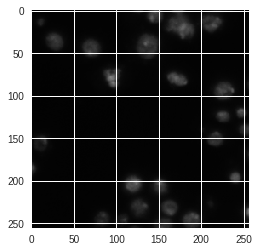

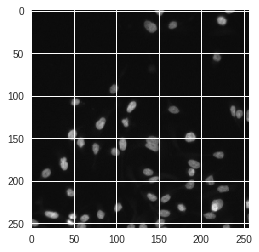

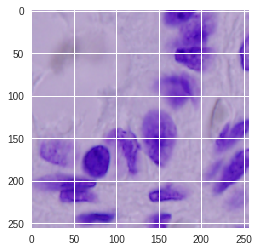

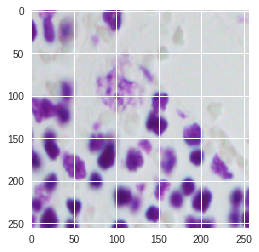

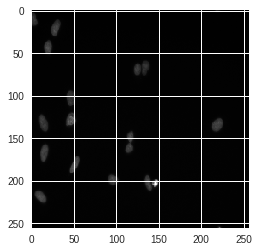

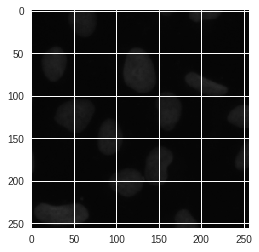

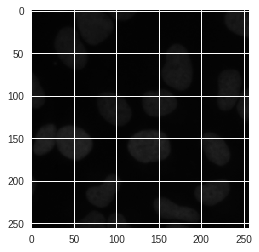

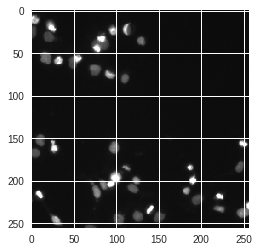

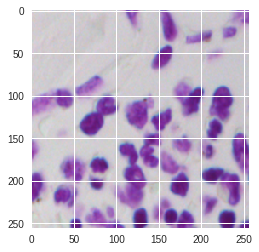

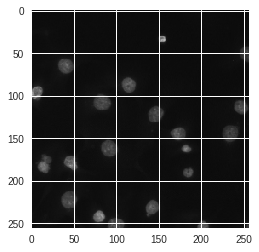

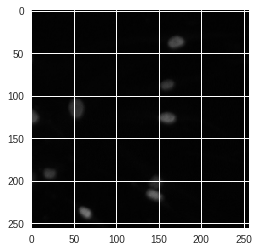

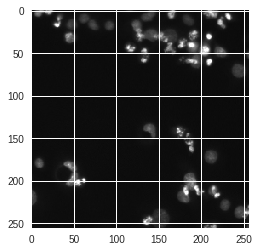

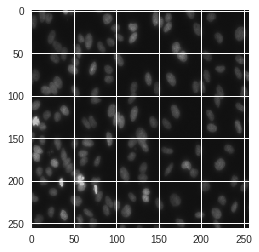

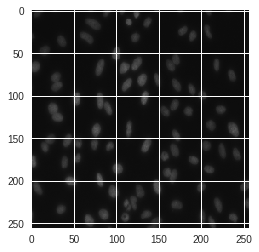

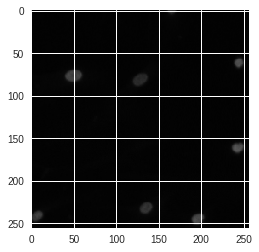

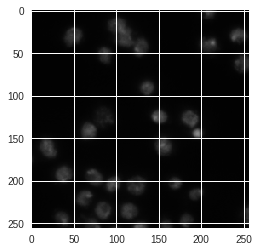

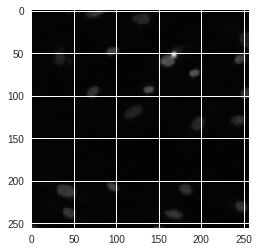

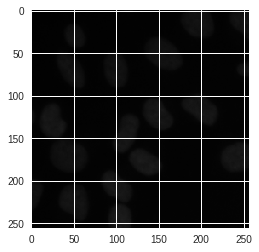

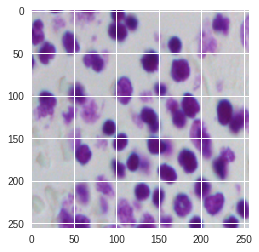

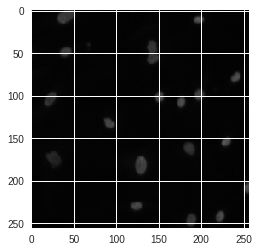

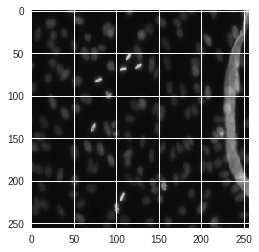

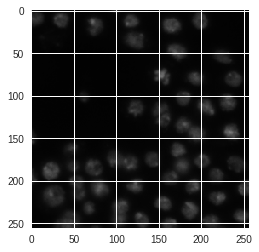

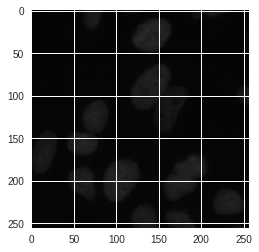

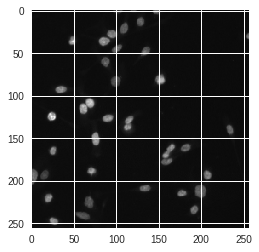

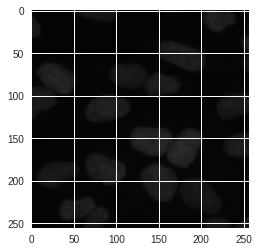

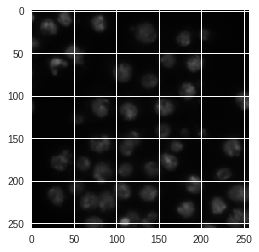

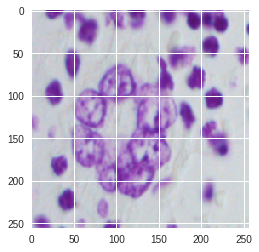

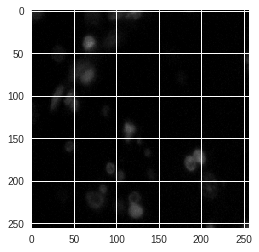

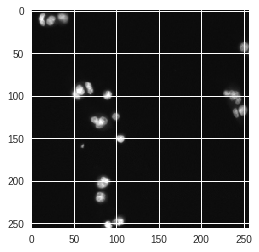

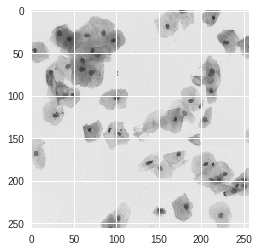

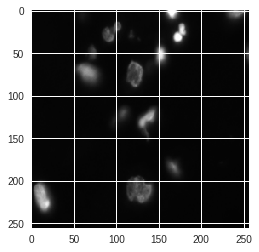

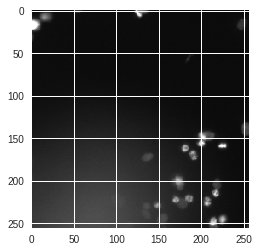

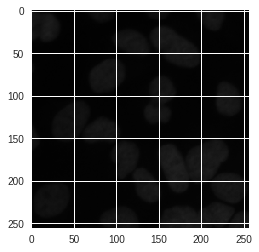

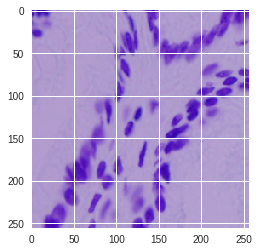

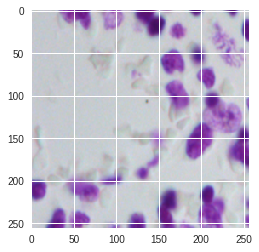

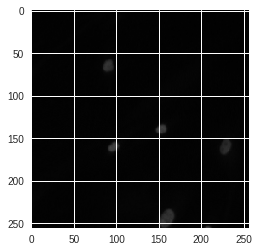

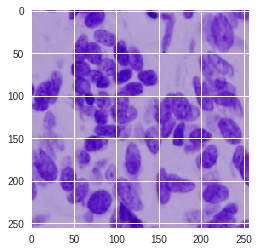

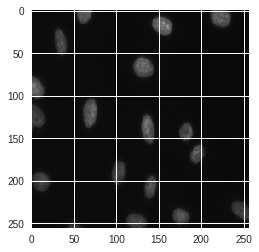

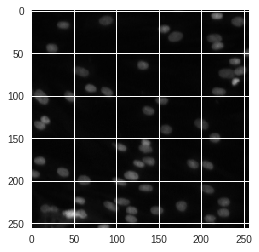

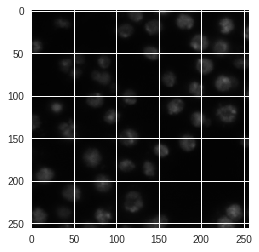

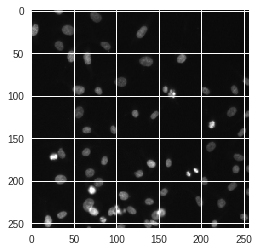

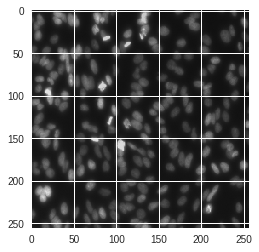

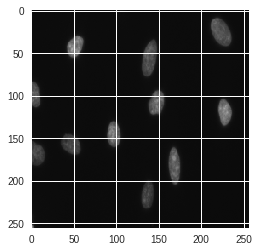

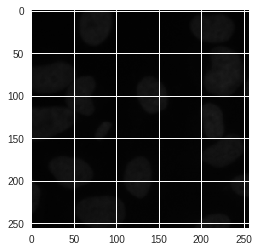

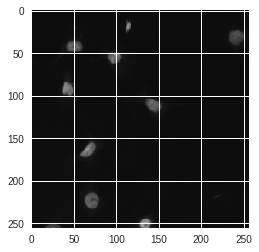

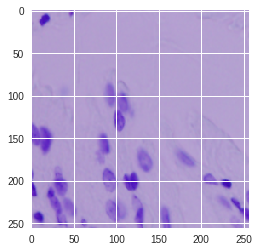

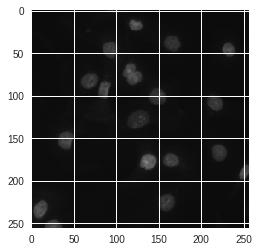

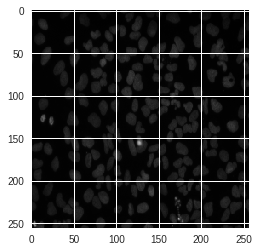

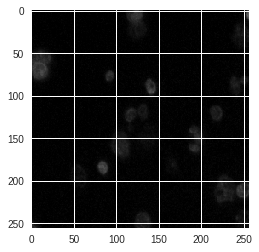

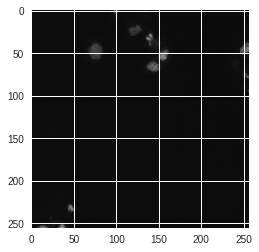

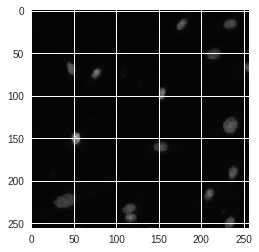

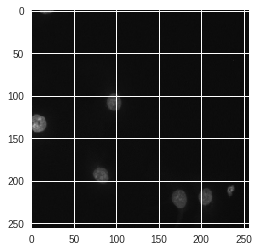

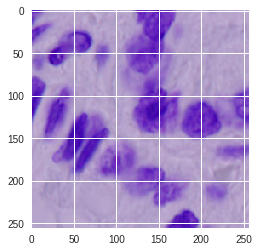

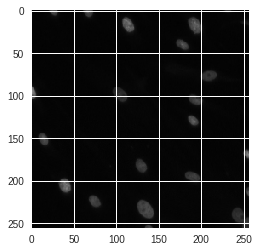

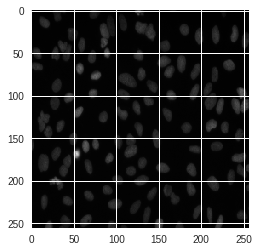

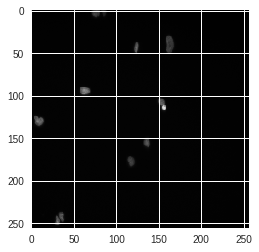

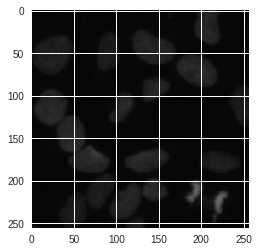

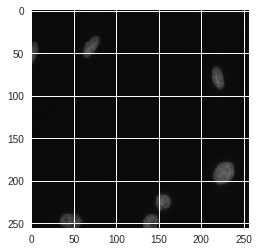

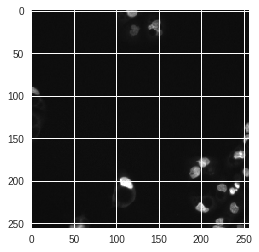

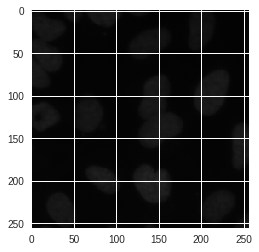

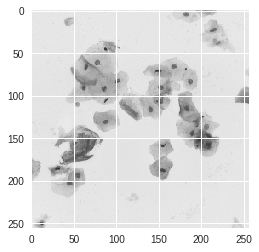

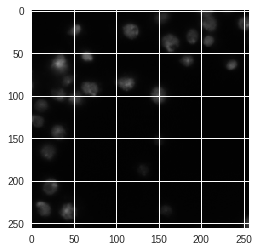

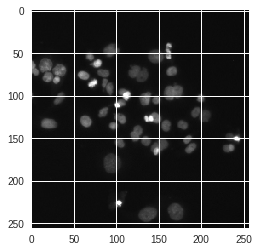

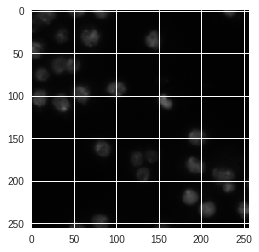

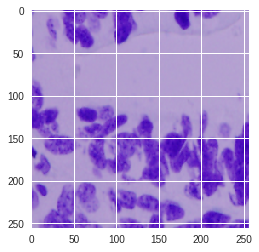

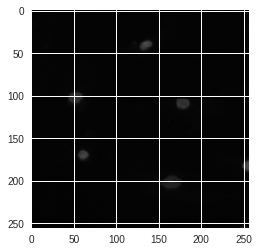

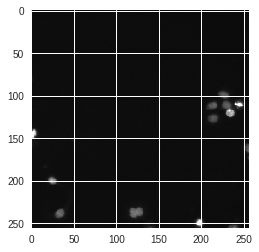

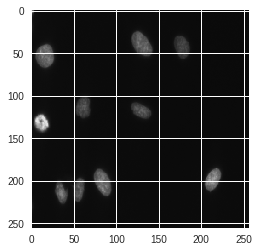

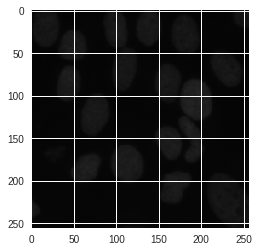

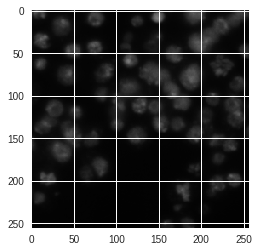

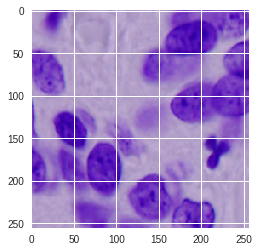

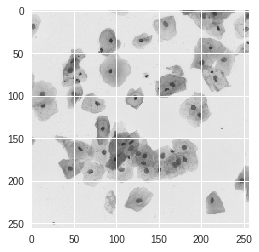

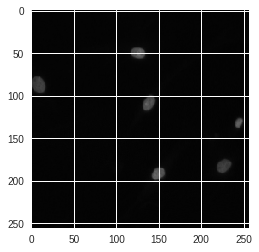

Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 4.3M of output have been discarded. 

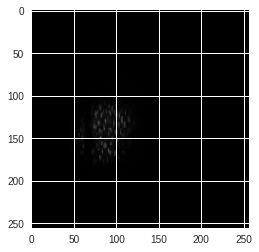

Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 22.1M of output have been discarded. 

In [16]:
for x in X_train:
  plt.imshow(x)
  plt.show()

In [7]:
X_train_aug = np.zeros((len(train_ids)*4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for i in tqdm(range(len(train_ids))):
  img = X_train_stand[i]
  X_train_aug[i] = img
  mask = Y_train[i]
  for q in range(1,4):
    imgRot = np.rot90(img, q)
    maskRot = np.rot90(mask, q)
    X_train_aug[len(train_ids) + 3*i + q - 1] = imgRot
    Y_train[len(train_ids) + 3*i + q - 1] = maskRot

  

100%|██████████| 670/670 [00:02<00:00, 323.73it/s]


In [0]:
#  Use inverse of DICE score in order to calculate accuracy, as they are using IOU metric
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, 3, 3, activation='relu', border_mode = 'same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, 3, 3, activation='relu', border_mode = 'same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, 3, 3, activation='relu',  border_mode = 'same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, 3, 3, activation='relu',  border_mode = 'same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, 3, 3, activation='relu',  border_mode = 'same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, 3, 3, activation='relu',  border_mode = 'same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, 3, 3, activation='relu',  border_mode = 'same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, 3, 3, activation='relu',  border_mode = 'same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, 3, 3, activation='relu',  border_mode = 'same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, 3, 3, activation='relu',  border_mode = 'same') (c5)

u6 = Deconvolution2D(128, 2, 2, output_shape = (None, 32, 32, 128), subsample=(2, 2), border_mode='same') (c5)
u6 = merge([u6, c4], mode='concat')
c6 = Conv2D(128, 3, 3, activation='relu',  border_mode = 'same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, 3, 3, activation='relu',  border_mode = 'same') (c6)

u7 = Deconvolution2D(64, 2, 2, output_shape = (None, 64, 64, 64), subsample=(2, 2), border_mode='same') (c6)
u7 = merge([u7, c3], mode='concat')
c7 = Conv2D(64, 3, 3, activation='relu',  border_mode = 'same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, 3, 3, activation='relu',  border_mode = 'same') (c7)

u8 = Deconvolution2D(32, 2, 2, output_shape = (None, 128, 128, 32), subsample=(2, 2), border_mode='same') (c7)
u8 = merge([u8, c2], mode='concat')
c8 = Conv2D(32, 3, 3, activation='relu',  border_mode = 'same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, 3, 3, activation='relu',  border_mode = 'same') (c8)

u9 = Deconvolution2D(16, 2, 2, output_shape = (None, 256, 256, 16), subsample=(2, 2), border_mode='same') (c8)
u9 = merge([u9, c1], mode='concat', concat_axis=3)
c9 = Conv2D(16, 3, 3, activation='relu',  border_mode = 'same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, 3, 3, activation='relu',  border_mode = 'same') (c9)

outputs = Conv2D(1, 1, 1, activation='sigmoid') (c9)

model = Model(input=[inputs], output=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(16, (2, 2), padding="same", strides=(2, 2))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/

In [10]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('cnn_best_model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train_aug, Y_train, validation_split=0.1, batch_size=32, nb_epoch=100, callbacks = [earlystopper, checkpointer])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 2412 samples, validate on 268 samples
Epoch 1/100
2412/2412 [==============================] - 90s 37ms/step - loss: 0.4608 - dice_coef: 0.1640 - val_loss: 0.4371 - val_dice_coef: 0.1578

Epoch 00001: val_loss improved from inf to 0.43713, saving model to cnn_best_model.h5
Epoch 2/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.4193 - dice_coef: 0.1565 - val_loss: 0.4135 - val_dice_coef: 0.1700

Epoch 00002: val_loss improved from 0.43713 to 0.41349, saving model to cnn_best_model.h5
Epoch 3/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.4011 - dice_coef: 0.1872 - val_loss: 0.3728 - val_dice_coef: 0.2792

Epoch 00003: val_loss improved from 0.41349 to 0.37280, saving model to cnn_best_model.h5
Epoch 4/100
 352/2412 [===>..........................] - ETA: 1:07 - loss: 0.3864 - dice_coef: 0.2360

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3791 - dice_coef: 0.2589 - val_loss: 0.3577 - val_dice_coef: 0.3238

Epoch 00004: val_loss improved from 0.37280 to 0.35771, saving model to cnn_best_model.h5
Epoch 5/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3706 - dice_coef: 0.2741 - val_loss: 0.3526 - val_dice_coef: 0.3200

Epoch 00005: val_loss improved from 0.35771 to 0.35262, saving model to cnn_best_model.h5
Epoch 6/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3659 - dice_coef: 0.2803 - val_loss: 0.3521 - val_dice_coef: 0.3430

Epoch 00006: val_loss improved from 0.35262 to 0.35208, saving model to cnn_best_model.h5
Epoch 7/100
 960/2412 [==========>...................] - ETA: 47s - loss: 0.3562 - dice_coef: 0.2899

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3572 - dice_coef: 0.2980 - val_loss: 0.3413 - val_dice_coef: 0.3377

Epoch 00007: val_loss improved from 0.35208 to 0.34127, saving model to cnn_best_model.h5
Epoch 8/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3727 - dice_coef: 0.2761 - val_loss: 0.3546 - val_dice_coef: 0.3435

Epoch 00008: val_loss did not improve
Epoch 9/100
2412/2412 [==============================] - 81s 34ms/step - loss: 0.3606 - dice_coef: 0.2896 - val_loss: 0.3371 - val_dice_coef: 0.3606

Epoch 00009: val_loss improved from 0.34127 to 0.33706, saving model to cnn_best_model.h5
Epoch 10/100
1248/2412 [==============>...............] - ETA: 38s - loss: 0.3514 - dice_coef: 0.3054

2412/2412 [==============================] - 81s 34ms/step - loss: 0.3539 - dice_coef: 0.3059 - val_loss: 0.3364 - val_dice_coef: 0.3590

Epoch 00010: val_loss improved from 0.33706 to 0.33644, saving model to cnn_best_model.h5
Epoch 11/100
2412/2412 [==============================] - 81s 34ms/step - loss: 0.3495 - dice_coef: 0.3150 - val_loss: 0.3321 - val_dice_coef: 0.3807

Epoch 00011: val_loss improved from 0.33644 to 0.33210, saving model to cnn_best_model.h5
Epoch 12/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3478 - dice_coef: 0.3199 - val_loss: 0.3271 - val_dice_coef: 0.3879

Epoch 00012: val_loss improved from 0.33210 to 0.32712, saving model to cnn_best_model.h5
Epoch 13/100
1024/2412 [===========>..................] - ETA: 45s - loss: 0.3580 - dice_coef: 0.3065

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3479 - dice_coef: 0.3180 - val_loss: 0.3293 - val_dice_coef: 0.3756

Epoch 00013: val_loss did not improve
Epoch 14/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3430 - dice_coef: 0.3257 - val_loss: 0.3220 - val_dice_coef: 0.3793

Epoch 00014: val_loss improved from 0.32712 to 0.32197, saving model to cnn_best_model.h5
Epoch 15/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3417 - dice_coef: 0.3283 - val_loss: 0.3238 - val_dice_coef: 0.3732

Epoch 00015: val_loss did not improve
Epoch 16/100
1536/2412 [==================>...........] - ETA: 28s - loss: 0.3395 - dice_coef: 0.3243

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3401 - dice_coef: 0.3317 - val_loss: 0.3217 - val_dice_coef: 0.3770

Epoch 00016: val_loss improved from 0.32197 to 0.32166, saving model to cnn_best_model.h5
Epoch 17/100
2412/2412 [==============================] - 81s 34ms/step - loss: 0.3378 - dice_coef: 0.3346 - val_loss: 0.3208 - val_dice_coef: 0.3861

Epoch 00017: val_loss improved from 0.32166 to 0.32080, saving model to cnn_best_model.h5
Epoch 18/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3352 - dice_coef: 0.3381 - val_loss: 0.3248 - val_dice_coef: 0.3836

Epoch 00018: val_loss did not improve
Epoch 19/100
1152/2412 [=============>................] - ETA: 41s - loss: 0.3402 - dice_coef: 0.3491

2412/2412 [==============================] - 81s 34ms/step - loss: 0.3372 - dice_coef: 0.3368 - val_loss: 0.3190 - val_dice_coef: 0.3804

Epoch 00019: val_loss improved from 0.32080 to 0.31901, saving model to cnn_best_model.h5
Epoch 20/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3339 - dice_coef: 0.3415 - val_loss: 0.3167 - val_dice_coef: 0.3921

Epoch 00020: val_loss improved from 0.31901 to 0.31673, saving model to cnn_best_model.h5
Epoch 21/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3328 - dice_coef: 0.3449 - val_loss: 0.3181 - val_dice_coef: 0.3917

Epoch 00021: val_loss did not improve
Epoch 22/100
1088/2412 [============>.................] - ETA: 43s - loss: 0.3315 - dice_coef: 0.3484

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3339 - dice_coef: 0.3407 - val_loss: 0.3174 - val_dice_coef: 0.3975

Epoch 00022: val_loss did not improve
Epoch 23/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3315 - dice_coef: 0.3469 - val_loss: 0.3169 - val_dice_coef: 0.3891

Epoch 00023: val_loss did not improve
Epoch 24/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3309 - dice_coef: 0.3461 - val_loss: 0.3155 - val_dice_coef: 0.3910

Epoch 00024: val_loss improved from 0.31673 to 0.31554, saving model to cnn_best_model.h5
Epoch 25/100
1728/2412 [====================>.........] - ETA: 22s - loss: 0.3300 - dice_coef: 0.3492

2412/2412 [==============================] - 82s 34ms/step - loss: 0.3300 - dice_coef: 0.3479 - val_loss: 0.3157 - val_dice_coef: 0.3994

Epoch 00025: val_loss did not improve
Epoch 26/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3288 - dice_coef: 0.3499 - val_loss: 0.3175 - val_dice_coef: 0.3923

Epoch 00026: val_loss did not improve
Epoch 27/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3308 - dice_coef: 0.3456 - val_loss: 0.3162 - val_dice_coef: 0.3850

Epoch 00027: val_loss did not improve
Epoch 28/100
1952/2412 [=======================>......] - ETA: 15s - loss: 0.3398 - dice_coef: 0.3323

2412/2412 [==============================] - 81s 34ms/step - loss: 0.3412 - dice_coef: 0.3260 - val_loss: 0.3212 - val_dice_coef: 0.3898

Epoch 00028: val_loss did not improve
Epoch 29/100
2412/2412 [==============================] - 82s 34ms/step - loss: 0.3339 - dice_coef: 0.3427 - val_loss: 0.3181 - val_dice_coef: 0.3887

Epoch 00029: val_loss did not improve
Epoch 00029: early stopping


In [11]:
model = load_model('cnn_best_model.h5', custom_objects={'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


65/65 [==============================] - 1s 13ms/step


In [30]:
!ls

Assignment2	 cnn_basic_model.h5  CNN_data_aug.csv	   cnn_elu_model.h5
Assignment2.zip  CNN.csv	     CNN_data_aug_elu.csv  datalab


/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


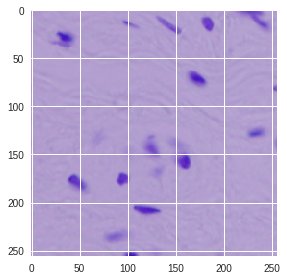

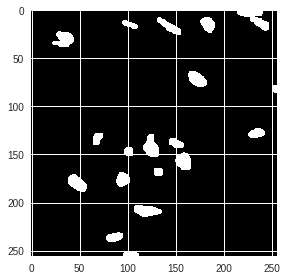

/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


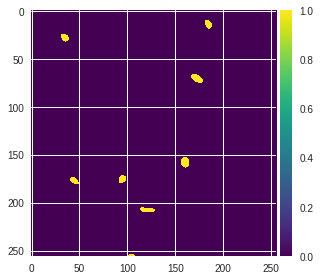

IndexError: ignored

In [16]:
# Don't run this again until images are saved!!!
###################################################################
###################################################################

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
imshow(np.squeeze(preds_val[ix]))
plt.show()

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('CNN_best_res.csv', index=False)

In [0]:
from google.colab import files

files.download('CNN_best_res.csv')